# Assignment 2 - INFO284
##### *By Espen Stokke, Tuva Bardal*

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
BATCH_SIZE = 100

trainset = datasets.FashionMNIST("", train=True, download=True,
                              transform = transforms.Compose([transforms.ToTensor()]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)


testset = datasets.FashionMNIST("", train=False, download=True,
                              transform = transforms.Compose([transforms.ToTensor()]))

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Extracting FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/raw


Extracting FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/raw


Extracting FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/raw




Extracting FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw
Processing...
Done!


In [0]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

    self.d1 = nn.Linear(64*20*20, 128)
    self.d2 = nn.Linear(128, 10)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)

    x = self.conv2(x)
    x = F.relu(x)

    x = self.conv3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=3, stride=1)

    x = x.flatten(start_dim = 1)

    x = self.d1(x)
    x = F.relu(x)

    logits = self.d2(x)
    out = F.softmax(logits, dim=1)
    return out


In [4]:
model = Net()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([100, 1, 28, 28])
torch.Size([100, 10])


In [0]:
learning_rate = 0.001
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

### Training the network

The following code trains the network and tests it on a test dataset, in this case with a batch size of 100, a learning rate of 0.001, and 10 epochs. This yields ~92.2% accuracy for the training set, and ~91.4% accuracy on the test set. 

We tried experimenting with different combinations of batch size, learning rate, and number of epochs. We concluded that a learning rate of 0.001 for larger batches and 0.0005 for smaller batches gave us the best results. Additionally, having a large batch size combined with a high number of epochs, tended to give results that may indicate overfitting. Some examples: 

For a batch size of 32, with a learning rate of 0.0005 and 6 epochs, the difference in accuracy between training set and the test set was ~0.5. The difference between the training set and the test set is a little bit smaller than with the parametres we chose to settle on, but but only by ~0.3.

A batch size of 256 with 25 epochs gave us ~96% accuracy on the training set, and ~91% accuracy on the test set. This was the largest difference we got while experimenting with the parametres, and seems to clearly overfit. 

For a batch size of 128 combined with fem epochs (5), we got a lower test error, with an accuracy of ~91.8, than training error, at ~89.8. As one would expect the test error to be higher than the training error - although this perhaps isn't a universal - we thought this was interesting. We were wondering whether it could have to do with the test set being only 1/6 of the training set. Since the sets should be expected to be fairly alike, and the smaller test set - in mere virtue of being smaller - may be less noisy, this could perhaps allow the network to more easily generalize over it. 

In [15]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 

Epoch: 0 | Loss: 1.6033 | Train Accuracy: 86.17
Epoch: 1 | Loss: 1.6015 | Train Accuracy: 86.34
Epoch: 2 | Loss: 1.6008 | Train Accuracy: 86.42
Epoch: 3 | Loss: 1.5956 | Train Accuracy: 86.96
Epoch: 4 | Loss: 1.5641 | Train Accuracy: 90.07
Epoch: 5 | Loss: 1.5540 | Train Accuracy: 91.10
Epoch: 6 | Loss: 1.5466 | Train Accuracy: 91.82
Epoch: 7 | Loss: 1.5430 | Train Accuracy: 92.20
Epoch: 8 | Loss: 1.5392 | Train Accuracy: 92.57
Epoch: 9 | Loss: 1.5369 | Train Accuracy: 92.80


In [18]:
test_acc = 0.0
labels_list = []
predicted_list = []

for i, (images, labels) in enumerate(testloader, 0):
    labels_list.append(labels)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    predicted_list.append(torch.max(outputs, 1)[1].view(100).cpu())
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/(i)))

Test Accuracy: 92.01


In [0]:
catalog = {0:"T-shirt/top",
          1:"Trouser",
          2:"Pullover",
          3:"Dress",
          4:"Coat",
          5:"Sandal",
          6:"Shirt",
          7:"Sneaker",
          8:"Bag",
          9:"Ankle boot"}

Guess: T-shirt/top
Actual: Shirt


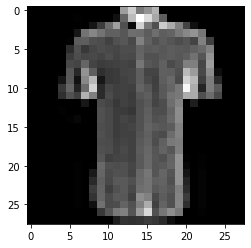

In [9]:
import matplotlib.pyplot as plt

i = 0

plt.imshow(images[i].view(28, 28).cpu(), cmap="gray")
print("Guess:", catalog[torch.max(outputs, 1)[1][i].item()])
print("Actual:", catalog[labels[i].item()])


# Saving and loading the model

In [0]:
torch.save(model.state_dict(), "Fashion_MNIST_Trained.pt")

In [0]:
#For downloading file from colab

#from google.colab import files
#files.download("/content/Fashion_MNIST_Trained.pt")

In [21]:
model.load_state_dict(torch.load("Fashion_MNIST_Trained.pt"))

<All keys matched successfully>

The neural network model has been uploaded to: 
https://github.com/ejstokke/INFO284_assignment2

In [0]:
from itertools import chain 

predicted_l = [predicted_list[i].tolist() for i in range(len(predicted_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predicted_l = list(chain.from_iterable(predicted_l))
labels_l = list(chain.from_iterable(labels_l))

# Confusion Matrix/Classification Report
The following code is used to compute the confusion matrix and produce a classification report. 
We retrieved this from:
https://www.kaggle.com/pankajj/fashion-mnist-with-pytorch-93-accuracy

In [23]:
import sklearn.metrics as metrics
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = multilabel_confusion_matrix(labels_l, predicted_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predicted_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.69      0.94      0.80      1000
           1       1.00      0.97      0.98      1000
           2       0.77      0.89      0.83      1000
           3       0.92      0.86      0.89      1000
           4       0.61      0.95      0.75      1000
           5       0.99      0.96      0.97      1000
           6       0.00      0.00      0.00      1000
           7       0.96      0.96      0.96      1000
           8       0.95      0.98      0.97      1000
           9       0.93      0.98      0.96      1000

    accuracy                           0.85     10000
   macro avg       0.78      0.85      0.81     10000
weighted avg       0.78      0.85      0.81     10000




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
stacked = torch.stack(labels_list)
stacked_preds = torch.stack(predicted_list)

list_of_labels = []
list_of_preds = []

for label_batch, pred_batch in zip(stacked, stacked_preds):
  for label, pred in zip(label_batch, pred_batch):
    list_of_labels.append(catalog[label.item()])
    list_of_preds.append(catalog[pred.item()])

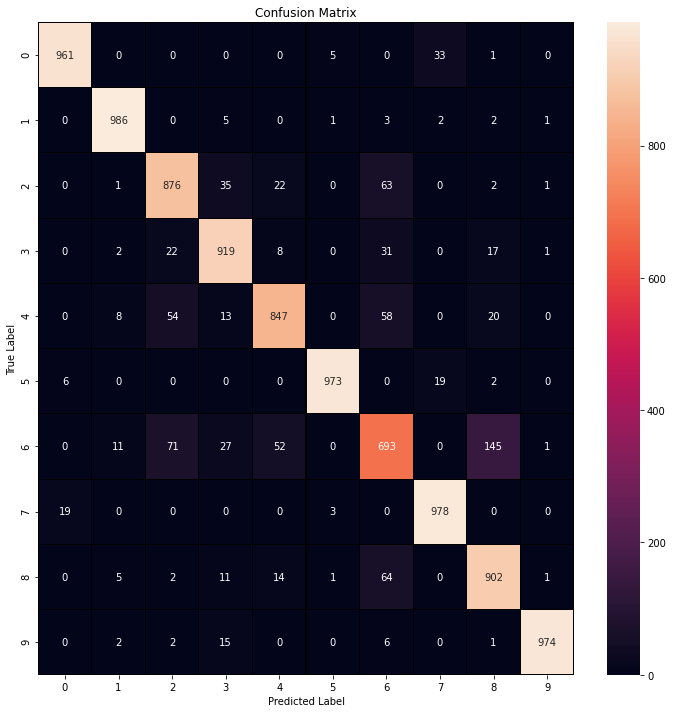

In [26]:
confusion_mtx = confusion_matrix(list_of_labels, list_of_preds)

f,ax = plt.subplots(figsize = (12,12))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, linecolor="black", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**A short explanation of the confusion matrix:**

When a model predicts, it can make different types of prediction errors. Therefore, accuracy alone isn't necessarily an ideal measure for how well our model predicts. The confusion matrix is a matrix representation of the model's prediction results, dividing the results into four categories: true positive, false positive, false negative, and true negative. These are represented in a 2*2 array, in the order in which they were listed, and the representation may help us gain more insight into how well, and how, our model predicts. 

The true positive and true negative correspond to correct predictions. The false negative is a label that is positive but has been deemed negative by the predictor, while the false positive is a negative label that has deemed positive by the predictor. Having a model that makes a lot of incorrect negative predictions will in many cases have largely different real world implications than having a model that makes a lot of incorrect positive predictions. 

In the classification report above, we can see that there are several columns with different labels, namely "precision", "recall", and "f1-score" (as well as support size). The precision column details how many of the positively predicted results are actually positive - this is a metric for controlling the amount of false positives. The recall, conversely, measures how many results, out of the total of positives, are actually labeled positive. This gives us an idea of how many false negatives we have. The F-measure is used to measure the accuracy by taking both the precision and the recall into account, balancing them so that we get a more accurate picture than what we would have if we relied on them separately. 

The report indicates that our model, for the most part, makes fairly accurate predictions overall, and generally has high recall and precision, as well as getting a high score with respects to the f-measure. However, it should be noted that the values for both the recall and the precision fluctuate somewhat. 

In [14]:
print(cm[9])

print("True positives: ", cm[9, 0, 0])
print("False positives: ", cm[9, 0, 1])
print("False negatives: ", cm[9, 1, 0])
print("True negatives: ", cm[9, 1, 1])



[[8930   70]
 [  20  980]]
True positives:  8930
False positives:  70
False negatives:  20
True negatives:  980
